<a href="https://colab.research.google.com/github/VEVELANDIA/Prueba-DataScientist-VictorVelandia/blob/main/Prueba_de_conocimientos_I_DNE_Davivienda%5BVictor_Velandia%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Departamento de Datos no Estructurados  </h1>


<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problmeas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información.
</p>


**Nota** <br>
Tenga en cuneta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habiliadades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

## Clasificación de Imágenes

### 1.Importe las imágenes
En la carpeta adjunta se encontrará con documentos tanto en blanco como con contenido. Su objetivo es generar un modelo que clasifique los elementos en "Con Contenido" y "Sin Contenido". Para eso puede utilizar reglas o modelos especificos.

In [1]:
#Teniendo en cuenta que la capeta de origen está en Drive se importan las bibliotecas google.colab y PIL (Python Imaging Library)
%%capture

#@title Librerias
!pip install -U -q PyDrive
# !pip install --upgrade -q gspread
!pip install --upgrade xlrd
!pip install --upgrade -q pandas
!pip install -q openpyxl
!pip install gspread==5.1.1
!pip install -q xlsxwriter
!pip install pyxlsb
from google.colab import files
import numpy    as np
import pandas   as pd
import datetime as dt
import gspread
from google.colab import auth
from google.auth import default
from openpyxl import load_workbook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pandas.tseries.offsets import MonthEnd
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

creds, _ = default()
gc = gspread.authorize(creds)
from PIL import Image

In [2]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title **Importación de imagenes**
input_doc_contenido = '1wORQk1cvxv7N4bTzmsFDuTBdNtQn3D69'
input_doc_sin = '1BPgrIx3IWUuzDkF2RWCSiFZbaD4U7EHN?usp=drive_link'

In [23]:
from fastai.vision.all import *
from pathlib import Path
path_train = Path('/content/sample_data/Imagenes/Entrenamiento')
path_test= Path('/content/sample_data/Imagenes/Muestra')
#dls = ImageDataLoaders.from_folder(path)
#dls.show_batch()
#os.path.exists(path)
#Image.open('/content/sample_data/Imagenes/Sin/page-156.png')

In [25]:
#Para validar que no hayan imagenes dañadas en la carpeta
failed = verify_images(get_image_files(path_train))
failed.map(Path.unlink)
len(failed)

0

### 2. Estructure la información
Debido a que las imagenes son archivos separados lo primero que debe hacer es importarlas (recuerde que una imagen es esencialmente un arreglo de vectores), puede esturcturarlas a su gusto y marcar de ser necesario aquellas que va usar como test de pruebas.

In [26]:
#Dataset de entrenamiento
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path_train)


In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.085971,0.485136,0.260870,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.229200,0.285467,0.130435,00:53
1,0.153504,0.171023,0.065217,00:51
2,0.105702,0.111765,0.021739,00:52


In [17]:
is_fill,_,probs = learn.predict(PILImage.create('/content/sample_data/Prueba/Ilegible.jpg'))
print(f"This is a: {is_fill}.")
print(f"Probability that document is fill: {probs[0]:.4f}")

This is a: Con.
Probability that document is fill: 0.5951


In [27]:
Img_muestra = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path_test)

### 3. Describa su Estrategia de Análisis
<p>Tiene libertad en la metodología para la clasificación. Aún así debe describir brevemente como realizará el análisis. Por ejemplo, si usará un modelo en donde requiera clasificar una cantidad pequeña de la data mencionelo o si planea condicionar la clasifiaciónes a reglas indique que reglas usará. Además si usa herramientas externas describalas y explique. </p>


Mi estrategia es utilizar un enfoque basado en aprendizaje automático supervisado para la clasificación de imágenes de documentos en las dos categorías solicitadas: contenido y sin contenido.

En primer lugar, realizar un preprocesamiento de las imágenes, redimensionándolas a un tamaño de 192x192 píxeles para asegurar una entrada consistente al modelo de clasificación.

Luego, utilizar la biblioteca fastai para crear un modelo de clasificación basado en la arquitectura ResNet18, conocida por su eficacia en tareas de visión por computadora. Entrenar el modelo utilizando el método fine_tune(), el cual ajustará los pesos del modelo a los datos específicos del conjunto de entrenamiento.

Durante el entrenamiento, utilizar métricas como el error_rate para evaluar el rendimiento y realizar ajustes en el modelo si es necesario.

En cuanto a las herramientas externas, el uso de las librerías fastai y PyTorch para el desarrollo del modelo y la manipulación de las imágenes. Estas bibliotecas proporcionan una amplia gama de funciones y algoritmos para el procesamiento de imágenes y el entrenamiento de modelos de aprendizaje automático.

### 4. Interpretación de Resultados
<p>Al final tiene que presentar la información en una matriz que muestre la calidad de su clasificación y evaluarla con la medida que guste. </p>
<br>
<img src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" >

[('Sin', 'Con', 1)]

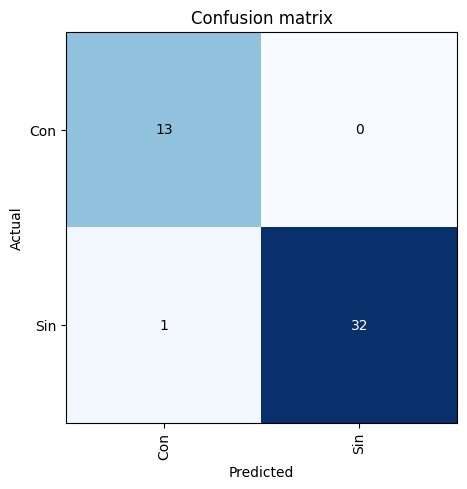

In [34]:
# Obtener las predicciones del modelo en un conjunto de imágenes de muestra
interp = ClassificationInterpretation.from_learner(learn)

# Realizar análisis e interpretación del modelo
interp.plot_confusion_matrix()
interp.most_confused()